In [ ]:
import pandas as pd
import pybedtools
import numpy as np
from collections import defaultdict
import pyranges
import scipy
import glob

import statsmodels.stats.multitest

import matplotlib.pyplot as plt
from scripts import aesthetics
import seaborn as sns

aesthetics.activate_paper_rcParams()

# Extract category genes

After some consideration and thought, I've realized that performing naive gene set enrichment on noncoding categories--which are themselves already gene subsets--is confounding two signals. The first signal is the enrichment that accompanies the category itself (an ATAC peak, for example, is likely to be enriched for genes responsible for certain processes). The second is a different kind of enrichment, focused on SVs.

Separating these influences is worth it, I think. To do so requires us to calculate the gene sets that are present within each category.

We'll do this for Ewing's and neuroblastoma.

# Read in our data

First, we read in the frameworks

In [82]:
#########################
### FRAMEWORK RESULTS ###
#########################

framework_results = []
for file in glob.glob('data/CWAS data for Jett/CWAS sum stats/*.txt'):
    if '12_26_23' not in file:
        continue

    disease = file.split('/')[-1].split('_')[0]
    
    sv_category = 'noncoding' if 'noncoding' in file else 'coding'
    af_category = 'singleton' if 'SINGLETON' in file else 'rare'
    
    data = pd.read_csv(file, sep='\t')
    data[['disease', 'sv_category', 'af_category']] = [disease, sv_category, af_category]
    framework_results.append(data)
        
framework_results = pd.concat(framework_results)

In [83]:
len(set(framework_results['category_name']))

17962

In [84]:
framework_results['disease'].value_counts()

neuroblastoma    8403
osteosarcoma     7193
ewing            6446
Name: disease, dtype: int64

So there are duplicate category names (for different diseases). That's fine--we don't actually care about the diseases for right now. But we will when we do the enrichment.

In [18]:
framework_schema = defaultdict(dict)

In [19]:
framework_schema = defaultdict(dict)
for file in glob.glob("data/CWAS data for Jett/CWAS frameworks/*.txt"):

    sv_category = "noncoding" if "noncoding" in file else "coding"
    suffix = file.split("/")[-1]
    if sv_category == "coding":
        disease = suffix.split('_')[2]
    else:
        disease = suffix.split('_')[3]

    data = pd.read_csv(file, sep="\t")
    framework_schema[disease][sv_category] = data

In [22]:
framework_schema['osteosarcoma']['noncoding']

,sv_type,frequency,functional_intersection,functional_category,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_NONCODING_BREAKPOINT,ewing_and_osteosarcoma_atac_peaks,PREDICTED_INTERGENIC,lof_constrained,expressed_in_muscle_skeletal,protein_coding
1,DEL,SINGLETON,PREDICTED_NONCODING_SPAN,osteosarcoma_chromHMM15_EnhBiv,PREDICTED_INTRONIC,ANY,ANY,cosmic_and_germline_CPGs
2,CPX_or_INV,NaN,ANY,osteosarcoma_H3K27Ac_peak,PREDICTED_PROMOTER,NaN,NaN,NaN
3,INS_ALL,NaN,NaN,osteosarcoma_ABC_MAX_enhancer,PREDICTED_UTR,NaN,NaN,NaN
4,ANY,NaN,NaN,osteosarcoma_chromHMM15_Enh,ANY,NaN,NaN,NaN
5,NaN,NaN,NaN,osteosarcoma_chromHMM15_TssAFlnk,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,ewing_and_osteosarcoma_atac_peaks_conserved,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,ewing_and_osteosarcoma_tad_boundary,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,osteosarcoma_chromHMM15_EnhBiv_conserved,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,osteosarcoma_chromHMM15_TssAFlnk_conserved,NaN,NaN,NaN,NaN


Some of these characteristics impose restrictions on genomic regions that are accessible in the analysis. THESE are the characteristics that we need to use to impose restrictions. They are as follows:

* Coding (other gene groups besides protein_coding are ignored, as they represent gene sets themselves)  
    * lof_constrained
    * missense_constrained
    * unconstrained
    * expressed_in_adrenal_gland  
    * protein_coding  

* Non-coding (other gene groups besides protein_coding are ignored, as they represent gene sets themselves)  
    * functional_categories  
    * lof_constrained
    * expressed_in_adrenal_gland
    * protein_coding

# Read in genes for non-functional categories

These are perhaps the easiest - Riaz has just provided these genes for us

In [23]:
paths = {'lof_constrained': 'data/CWAS data for Jett/lof_constrained_genes_7_31_23 (1).txt',
         'missense_constrained': 'data/CWAS data for Jett/missense_constrained_genes_7_31_23.txt',
         'unconstrained': 'data/CWAS data for Jett/unconstrained_genes_7_31_23.txt',
         'expressed_in_adrenal_gland': 'data/CWAS data for Jett/top_expressed_in_adrenal_gland_7_31_23 (1).txt',
         'protein_coding': 'data/CWAS data for Jett/gencode_hg38_protein_coding_genes_for_annotation_7_31_23 (1).txt',
         'cosmic_and_germline_CPGs': 'data/CWAS data for Jett/cosmic_cancer_genes_tier_one_and_germline_CPGs_10_23_23 (1).txt',
         'expressed_in_muscle_skeletal': 'data/CWAS data for Jett/top_expressed_in_muscle_skeletal_7_31_23.txt'}

gene_restrictions = {}
for label, path in paths.items():
    data = pd.read_csv(path)
    data = data[~data['value'].str.startswith('ENSG00')]
    data = data['value'].tolist()
    
    gene_restrictions[label] = data

In [28]:
print(len(gene_restrictions['expressed_in_adrenal_gland']))
print(len(gene_restrictions['expressed_in_muscle_skeletal']))
print(len(gene_restrictions['protein_coding']))

9505
7566
19201


Great.

# Read in SVs

Not actually required for our category analysis, but used later

In [25]:
# define SVs and dosages for discovery and validation
sv_path = "gs://vanallen-pedsv-analysis/beds/archive/v2.5.2/PedSV.v2.5.2.full_cohort.analysis_samples.sites.bed.gz"

In [26]:
svs = pd.read_csv(sv_path, sep="\t", usecols=[0, 1, 2, 3, 42])

In [29]:
svs.head(2)

,#chrom,start,end,name,PREDICTED_NEAREST_TSS
0,chr1,12000,30001,PedSV.2.5.2_CNV_chr1_1,OR4F5
1,chr1,12000,40001,PedSV.2.5.2_DUP_chr1_1,OR4F5


# Identify genes within functional categories

We need to read in the genomic locations of the categories. Riaz has kindly already compiled these.

In [30]:
category_regions = pd.read_csv('data/CWAS data for Jett/PedSV.noncoding_annotations.7_18_23.bed.gz', sep ='\t')

In [31]:
category_regions.head(2)

,#chrom,start,end,element_class
0,chr1,9944,10676,ewing_and_osteosarcoma_atac_peaks
1,chr1,9944,10676,ewing_and_osteosarcoma_atac_peaks_unconserved


In [32]:
regions = list(category_regions['element_class'].unique())

In [33]:
category_regions['element_class'].unique()

array(['ewing_and_osteosarcoma_atac_peaks',
       'ewing_and_osteosarcoma_atac_peaks_unconserved',
       'neuroblastoma_atac_peaks', 'neuroblastoma_atac_peaks_unconserved',
       'ewing_chromHMM15_Quies', 'osteosarcoma_chromHMM15_Quies',
       'neuroblastoma_chromHMM15_Quies', 'neuroblastoma_chromHMM15_Enh',
       'neuroblastoma_chromHMM15_Enh_conserved',
       'neuroblastoma_chromHMM15_EnhG',
       'neuroblastoma_chromHMM15_EnhG_conserved',
       'neuroblastoma_chromHMM15_EnhG_unconserved',
       'osteosarcoma_chromHMM15_Quies_unconserved',
       'ewing_chromHMM15_Quies_unconserved',
       'neuroblastoma_chromHMM15_Quies_unconserved',
       'neuroblastoma_H3K27Ac_peak',
       'neuroblastoma_H3K27Ac_peak_unconserved',
       'neuroblastoma_chromHMM15_Enh_unconserved',
       'ewing_chromHMM15_EnhBiv', 'ewing_chromHMM15_EnhBiv_unconserved',
       'neuroblastoma_chromHMM15_TssAFlnk',
       'neuroblastoma_chromHMM15_TssAFlnk_unconserved',
       'ewing_H3K27Ac_peak', 'ewing

And let's quickly verify that these functional elements represent the sum total of those present in our categories.

In [34]:
category_to_functional = {c: c.split('.')[3] if len(c.split('.')) == 8 else np.nan for c in framework_results['category_name'].tolist()}
framework_results['functional_category'] = [category_to_functional[c] for c in framework_results['category_name'].tolist()]

In [35]:
set(framework_results['functional_category']) - set(category_regions['element_class'])

{nan}

Note that this file takes the step of defining "unconserved" and "conserved" regions. We ignore the unconserved regions, as they're not in any of our categories. But this file lists all the regions along with their coordinates. Let's give a value for each of the regions so we know which is which.

In [36]:
category_regions = category_regions[~category_regions['element_class'].str.contains('_unconserved')]

In [37]:
set(framework_results['functional_category']) - set(category_regions['element_class'])

{nan}

In [38]:
category_regions['element_class'] = category_regions['element_class'] + '_' + np.array(category_regions.index).astype(str)

## Download genes

Next, we extract out the genic locations, for cross-reference with our category regions. We use gencode.

In [39]:
gtf = pd.read_csv(
    "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.basic.annotation.gtf.gz",
    comment="#",
    sep="\t",
    header=None,
    names=[
        "seqname",
        "source",
        "feature",
        "start",
        "end",
        "score",
        "strand",
        "frame",
        "attribute",
    ],
)

In [40]:
genes = gtf.query('feature == "gene"').reset_index(drop = True)

characteristics = {}
for index, row in genes.iterrows():
    gene_data = row['attribute'].split('; ')
    gene_data = {field.split(' ')[0]: field.split(' ')[1].strip(';') for field in gene_data}
    gene_data = {key: val.strip('"') for key, val in gene_data.items()}
    characteristics[index] = gene_data
    
characteristics = pd.DataFrame(characteristics).T

genes = pd.concat([genes, characteristics], axis = 1)

In [41]:
# drop genes in PAR
genes = genes[~(genes['tag'] == 'PAR')
              & (genes['gene_type'] == 'protein_coding')]

In [42]:
genes.shape

(20024, 17)

We subset this to genes that are in our dataset.

In [43]:
gene_ref = gene_restrictions['protein_coding']
missing_genes = set(gene_ref) - set(genes['gene_name'])
print(len(gene_ref), len(missing_genes))

19201 109


So a few genes are present in our reference dataset but missing from the gtf. What are these genes?

In [44]:
print(sorted(missing_genes))

['ACTMAP', 'ADISSP', 'AFG2A', 'AFG2B', 'AIRIM', 'ARK2C', 'ARK2N', 'C1orf202', 'C4B_2', 'CCL3L3', 'CEP15', 'CFAP144', 'CFAP68', 'CFAP90', 'CFAP96', 'CHD9NB', 'CIMAP1A', 'CIMAP1B', 'CIMAP1C', 'CIMAP1D', 'CIMAP2', 'CIMAP3', 'CIMIP1', 'CIMIP2A', 'CIMIP2B', 'CIMIP2C', 'CIMIP3', 'CIMIP4', 'CIST1', 'CT47C1', 'DUSP13A', 'DUSP13B', 'EEIG1', 'EEIG2', 'FAM200C', 'FIRRM', 'FREY1', 'GK3', 'GSTT1', 'GTF2H2C_2', 'HAPSTR2', 'HLA-DRB3', 'HLA-DRB4', 'IFT25', 'IFT56', 'IFT70A', 'IFT70B', 'IGBP1C', 'KIR2DL5A', 'KIR2DL5B', 'KIR2DS1', 'KIR2DS5', 'KPLCE', 'LASP1NB', 'LIAT1', 'LYSET', 'MISFA', 'MIURF', 'MRFAP1L2', 'NHERF1', 'NHERF2', 'NHERF4', 'OR14L1', 'OR8U8', 'OR8U9', 'OR9G9', 'PRAMEF22', 'PRR23E', 'QNG1', 'RLIG1', 'RPSA2', 'SAXO3', 'SAXO4', 'SAXO5', 'SCAND3', 'SMIM47', 'SPADH', 'SPATA31F1', 'SPATA31F3', 'SPMAP1', 'SPMAP2', 'SPMAP2L', 'SPMIP1', 'SPMIP10', 'SPMIP11', 'SPMIP2', 'SPMIP3', 'SPMIP4', 'SPMIP5', 'SPMIP6', 'SPMIP7', 'SPMIP8', 'SPMIP9', 'SSU72L1', 'SSU72L2', 'SSU72L3', 'SSU72L4', 'SSU72L5', 'SSU72L

In [45]:
gtf[gtf['attribute'].str.contains('HLA-DRB3')]

,seqname,source,feature,start,end,score,strand,frame,attribute


It's not at all obvious to me why these genes are missing, but there is truly no mention of them in the GTF (even in non-gene entries). So we move on, further restricting our analysis to these genes.

In [46]:
gene_subset = genes[genes['gene_name'].isin(gene_ref)]
print(gene_subset.shape[0], len(set(gene_subset['gene_name'])))

19102 19092


So there are some duplicates. In looking at them, it's not entirely obvious which is which.

In [47]:
gene_counts = gene_subset['gene_name'].value_counts()
duplicates = gene_counts[gene_counts > 1]

# some heuristics to get proper genes
duplicate_gene_subset = gene_subset[gene_subset['gene_name'].isin(duplicates.index)]
duplicate_gene_subset.shape

(19, 17)

In [48]:
gene_subset = gene_subset.drop_duplicates(subset = ['gene_name'])
gene_subset.shape

(19092, 17)

In [49]:
# its also useful for later binomial calculations to export gene lengths here
gene_subset['length'] = gene_subset['end'] - gene_subset['start']


In [50]:
gene_subset[['gene_name', 'seqname', 'start', 'end', 'length']].to_csv('data/cwas-results/gene-lengths.csv', index = False)

## Do the intersection

We intersect the category regions with the genes. This will yield a list of genes that are present in these categories.

Some category regions, however, will not intersect genes. This will yield no gene and be valid for most comparisons. For some noncoding analyses, however, the nearest gene must also be included in the analysis, since `PREDICTED_INTERGENIC` can yield this.

Incorporating this is extremely frustrating, as it's not clear how to optimally do this. For example, consider a region, with a closest gene. There are many possibilities:

1. The closest gene is within the region
2. The closest gene is outside the region, but there is also a gene in the region
3. The closest gene is downstream, but at another point in the region, the closest gene is upstream

Which of these is the case depends very strongly on where the SV is located within the region. However, we can't use the SV locations, as the point of gene set enrichment is to examine _which genes COULD be impacted_. This is... unresolvable.

I suppose the best way forward is to assume the following:

1. If a gene is within a region, it will be closest to all SVs in that region if those SVs are noncoding
2. If a gene is not within a region, the closest gene to the region will be the closest gene to all SVs

In [51]:
# do the intersection with pybedtools.
category_bed = pybedtools.BedTool(
    category_regions.to_csv(sep="\t", index=False, header=False), from_string=True
)

gene_bed = pybedtools.BedTool(
    gene_subset[['seqname', 'start', 'end', 'gene_name']].to_csv(sep="\t", index=False, header=False),
    from_string=True,
)
/
genes_in_regions = category_bed.intersect(gene_bed, wao=True)
genes_in_regions = genes_in_regions.to_dataframe()

In [52]:
genes_in_regions['category'] = genes_in_regions['name'].apply(lambda n: '_'.join(n.split('_')[:-1]))
genes_in_regions = genes_in_regions.rename(columns = {'thickEnd': 'gene'})

In [53]:
genes_in_regions.head(3)

,chrom,start,end,name,score,strand,thickStart,gene,itemRgb,category
0,chr1,9944,10676,ewing_and_osteosarcoma_atac_peaks_0,.,-1,-1,.,0,ewing_and_osteosarcoma_atac_peaks
1,chr1,9949,10686,neuroblastoma_atac_peaks_2,.,-1,-1,.,0,neuroblastoma_atac_peaks
2,chr1,10000,13000,ewing_chromHMM15_Quies_4,.,-1,-1,.,0,ewing_chromHMM15_Quies


So now, for regions that do not contain a gene, we examine the closest gene.

In [54]:
regions_without_genes = genes_in_regions.query('score == "."')[['chrom', 'start', 'end', 'name']].sort_values(by = ['chrom', 'start'])


In [55]:
# do the intersection with pybedtools.
without_genes_bed = pybedtools.BedTool(
    regions_without_genes.to_csv(sep="\t", index=False, header=False), from_string=True
)

gene_bed = pybedtools.BedTool(
    gene_subset[['seqname', 'start', 'end', 'gene_name']].sort_values(by = ['seqname', 'start']).to_csv(sep="\t", index=False, header=False),
    from_string=True,
)

closest_genes = without_genes_bed.closest(gene_bed, d=True)
closest_genes = closest_genes.to_dataframe()

In [56]:
closest_genes['category'] = closest_genes['name'].apply(lambda n: '_'.join(n.split('_')[:-1]))
closest_genes = closest_genes.rename(columns = {'thickEnd': 'gene'})

In [57]:
closest_genes.head(2)

,chrom,start,end,name,score,strand,thickStart,gene,itemRgb,category
0,chr1,9944,10676,ewing_and_osteosarcoma_atac_peaks_0,chr1,65419,71585,OR4F5,54744,ewing_and_osteosarcoma_atac_peaks
1,chr1,9949,10686,neuroblastoma_atac_peaks_2,chr1,65419,71585,OR4F5,54734,neuroblastoma_atac_peaks


The number of genes identified through this process and the size of our original regions without genes are not the same:

In [58]:
regions_without_genes.shape, closest_genes.shape

((665846, 4), (666375, 10))

What gives?

In [59]:
region_counts = closest_genes['name'].value_counts()
duplicate_regions = region_counts[region_counts > 1]

closest_genes[closest_genes['name'] == 'neuroblastoma_chromHMM15_Quies_851491']

,chrom,start,end,name,score,strand,thickStart,gene,itemRgb,category
493230,chr5,141015815,141038615,neuroblastoma_chromHMM15_Quies_851491,chr5,140786136,141012347,PCDHA1,3469,neuroblastoma_chromHMM15_Quies
493231,chr5,141015815,141038615,neuroblastoma_chromHMM15_Quies_851491,chr5,140794852,141012347,PCDHA2,3469,neuroblastoma_chromHMM15_Quies
493232,chr5,141015815,141038615,neuroblastoma_chromHMM15_Quies_851491,chr5,140801028,141012347,PCDHA3,3469,neuroblastoma_chromHMM15_Quies
493233,chr5,141015815,141038615,neuroblastoma_chromHMM15_Quies_851491,chr5,140806929,141012347,PCDHA4,3469,neuroblastoma_chromHMM15_Quies
493234,chr5,141015815,141038615,neuroblastoma_chromHMM15_Quies_851491,chr5,140821604,141012347,PCDHA5,3469,neuroblastoma_chromHMM15_Quies
493235,chr5,141015815,141038615,neuroblastoma_chromHMM15_Quies_851491,chr5,140827958,141012347,PCDHA6,3469,neuroblastoma_chromHMM15_Quies
493236,chr5,141015815,141038615,neuroblastoma_chromHMM15_Quies_851491,chr5,140834248,141012347,PCDHA7,3469,neuroblastoma_chromHMM15_Quies
493237,chr5,141015815,141038615,neuroblastoma_chromHMM15_Quies_851491,chr5,140841187,141012347,PCDHA8,3469,neuroblastoma_chromHMM15_Quies
493238,chr5,141015815,141038615,neuroblastoma_chromHMM15_Quies_851491,chr5,140847772,141012347,PCDHA9,3469,neuroblastoma_chromHMM15_Quies
493239,chr5,141015815,141038615,neuroblastoma_chromHMM15_Quies_851491,chr5,140855883,141012347,PCDHA10,3469,neuroblastoma_chromHMM15_Quies


I see. This is an issue with pseudogenes, etc. Well, I suppose we have to keep them.

In [60]:
genes_in_regions = genes_in_regions.query('gene != "."')

We now convert these to lookup dictionaries for easy access.

In [62]:
region_gene_lookup = {}

for disease, schema in framework_schema.items():
    
    region_gene_lookup[disease] = defaultdict(dict)
    
    for region in schema['noncoding']['functional_category']:
        within_genes = set(genes_in_regions[genes_in_regions['category'] == region]['gene'])
        close_genes = set(closest_genes[closest_genes['category'] == region]['gene'])
        
        region_gene_lookup[disease][region]['within'] = within_genes
        region_gene_lookup[disease][region]['closest'] = close_genes

# Create our gene lists

Alright, now for the tricky part. For each category, we need to create a gene list. It's pretty clear to me that the best way to store this is in a sparse matrix. Each row will be a gene, and each column a category. The element will be 1 if that gene is eligible for that category and 0 otherwise.

Each category starts with all of the reference genes being eligible and then progressively shrinks to fit the category's requirements.

In [63]:
gene_ref = gene_subset['gene_name'].tolist()
len(gene_ref)

19092

## Some examples

So ~19k genes are eligible as the "master" protein_coding list. An example, let's consider a few categories:

In [86]:
example_category = 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding'

This category receives no reductions whatsoever.

In [87]:
test_cat = 'ANY.SINGLETON.PREDICTED_NONCODING_SPAN.neuroblastoma_H3K27Ac_peak.PREDICTED_INTRONIC.ANY.ANY.protein_coding'

This category receives one reduction--from `neuroblastoma_H3K27Ac_peak`

In [88]:
neuroblastoma_H3K27Ac_peak_genes = region_gene_lookup['neuroblastoma']['neuroblastoma_H3K27Ac_peak']['within']
len(neuroblastoma_H3K27Ac_peak_genes)

13580

In [89]:
len(set(neuroblastoma_H3K27Ac_peak_genes) & set(gene_ref))

13580

So from 19k genes down to 13.5k genes.

In [90]:
test_cat = 'ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding'

This framework receives two reductions--one for `neuroblastoma_tad_boundary` and one for `genic_relationship == "ANY"`, which contains within it `genic_relationship == "INTERGENIC"`. This means we need to include the closest genes as well.

In [91]:
neuroblastoma_tad_boundary_genes = region_gene_lookup['neuroblastoma']['neuroblastoma_tad_boundary']['within']
neuroblastoma_tad_boundary_genes_closest = region_gene_lookup['neuroblastoma']['neuroblastoma_tad_boundary']['closest']
print(len(neuroblastoma_tad_boundary_genes), len(neuroblastoma_tad_boundary_genes_closest))

neuroblastoma_tad_boundary_genes = neuroblastoma_tad_boundary_genes | neuroblastoma_tad_boundary_genes_closest
len(neuroblastoma_tad_boundary_genes)

4389 2153


5936

## Formalize the calculation of gene lists

We define a quick function to make this easier. Poor coding practice to use globals, but eh.

In [92]:
def category_to_gene_list(disease, category, sv_effect, genes_in_regions, closest_genes, region_gene_lookup, reference_list):
    '''Takes in a category and its effect (coding or non-coding) and returns a gene list of eligible genes in that category.
    Takes in a reference gene list that will be subset as well.'''
    
    
    framework = framework_schema[disease]
    category_genes = set(reference_list.copy())
    
    if sv_effect == "coding":
        components = dict(zip(framework['coding'].columns, category.split('.')))
            
    elif sv_effect == "noncoding":
        components = dict(zip(framework['noncoding'].columns, category.split('.')))
        
    # we only analyze two gene groups
    gene_group = components['gene_group']
    if gene_group not in ['protein_coding', 'cosmic_and_germline_CPGs']:
        raise ValueError(f'gene_group {gene_group} not valid.')
        
    # apply constraints
    constraint = components['constraint']
    if components['constraint'] in ['lof_constrained', 'missense_constrained', 'unconstrained']:
        category_genes = category_genes & set(gene_restrictions[constraint])
    
    # apply expression
    if components['expression'] in ['expressed_in_adrenal_gland', 'expressed_in_muscle_skeletal']:
        category_genes = category_genes & set(gene_restrictions[components['expression']])
    
    # if the sv is a non-coding SV, there are still more restrictions
    if sv_effect == "noncoding":
        
        functional_lookup = region_gene_lookup[disease]
        
        # apply gene group if necessary
        if components['gene_group'] == 'cosmic_and_germline_CPGs':
            category_genes = category_genes & set(gene_restrictions['cosmic_and_germline_CPGs'])
            
        # then, assess the functional category
        func_cat = components['functional_category']
        func_cat_genes = functional_lookup[func_cat]['within']
        
        # then, we check the genic relationship, which determines whether we need the closest genes as well
        if components['genic_relationship'] in ['ANY', 'PREDICTED_INTERGENIC']:
            cat_closest_genes = functional_lookup[func_cat]['closest']
            func_cat_genes = func_cat_genes | cat_closest_genes
            
        # with this in mind, merge
        category_genes = category_genes & func_cat_genes
        
    return category_genes

In [93]:
test_cat = 'ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding'
category_genes = category_to_gene_list('neuroblastoma', test_cat, 'noncoding', genes_in_regions, closest_genes, region_gene_lookup, gene_ref)
print(len(category_genes))

5936


## Create our category-gene matrix

In [94]:
included_categories = framework_results[framework_results['category_name'].apply(lambda cn: cn.split('.')[-1] in ['protein_coding', 'cosmic_and_germline_CPGs'])].reset_index(drop = True)

# we drop duplicate categories here, since disease doesn't matter
included_categories = included_categories.drop_duplicates(subset = 'category_name')

In [95]:
category_gene_matrix = pd.DataFrame(0, index = included_categories['category_name'].tolist(), columns = sorted(gene_ref))

In [96]:
category_gene_matrix.shape

(17454, 19092)

In [97]:
for index, row in included_categories.iterrows():
    if index % 100 == 0:
        print(index, end = ', ')
        
    disease = row['disease']
    category = row['category_name']
    sv_category = row['sv_category']
    
    if category.split('.')[-1] not in ['protein_coding', 'cosmic_and_germline_CPGs']:
        continue
    
    genes_in_category = category_to_gene_list(disease, category, sv_category, genes_in_regions, closest_genes, region_gene_lookup, gene_ref)
    
    category_gene_matrix.loc[category, genes_in_category] = 1

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 4000, 4300, 4400, 4500, 5100, 5300, 5400, 5500, 5600, 5800, 5900, 6000, 6200, 6400, 6500, 6700, 6800, 6900, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12900, 13000, 13100, 13400, 13500, 13600, 13800, 14000, 14100, 14200, 14600, 14800, 15000, 15100, 15300, 15600, 16000, 16200, 16400, 16700, 16800, 16900, 17000, 17100, 17200, 17300, 17400, 17500, 17600, 17700, 17800, 17900, 18000, 18200, 18300, 18400, 18500, 18600, 18700, 18800, 18900, 19000, 19100, 19200,

In [98]:
counts = category_gene_matrix.sum(axis = 1)
counts[counts > 1].sort_values()

INS_ALL.SINGLETON.ANY.fragile_site.ANY.ANY.ANY.cosmic_and_germline_CPGs                                                            2
ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.fragile_site.ANY.ANY.ANY.cosmic_and_germline_CPGs                                     2
INS_ALL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.fragile_site.ANY.ANY.ANY.cosmic_and_germline_CPGs                                 2
INS_ALL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.fragile_site.ANY.lof_constrained.expressed_in_adrenal_gland.protein_coding        2
INS_ALL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.fragile_site.PREDICTED_INTRONIC.ANY.ANY.cosmic_and_germline_CPGs                  2
                                                                                                                               ...  
ANY.RARE.ANY.ANY.ANY.protein_coding                                                                                            19092
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.pro

We start to see some of the severe restrictions for some of these categories

# Export

In [99]:
category_gene_matrix.index.name = 'category'

In [100]:
category_gene_matrix.to_csv('data/cwas-results/category-gene-matrix.csv')

# Quantify distances between non-coding SVs and their nearest genes

This is important because downstream work will rely on this for filtering.

In [101]:
def calculate_distance(sv, gene):
    
    # If they overlap, the distance is 0
    if not (sv['end_sv'] < gene['start_gene'] or sv['start_sv'] > gene['end_gene']):
        return 0

    # If they do not overlap
    else:
        return min(abs(sv['start_sv'] - gene['end_gene']), abs(sv['end_sv'] - gene['start_gene']))

In [102]:
# examine intergenic svs
intergenic_svs = svs[~pd.isnull(svs['PREDICTED_NEAREST_TSS'])]

# drop those labelled as affecting two genes
intergenic_svs = intergenic_svs[~intergenic_svs['PREDICTED_NEAREST_TSS'].str.contains(',')]

# drop those affecting genes not in our reference
intergenic_svs = intergenic_svs[intergenic_svs['PREDICTED_NEAREST_TSS'].isin(gene_subset['gene_name'].tolist())]

# merge with gene locations
intergenic_svs = intergenic_svs.merge(gene_subset[['seqname', 'start', 'end', 'gene_name']], 
                                 left_on = 'PREDICTED_NEAREST_TSS', 
                                 right_on = 'gene_name',
                                     suffixes = ['_sv', '_gene'])

# check that all chroms are the same
assert (intergenic_svs['#chrom'] == intergenic_svs['seqname']).all()

sv_locs = intergenic_svs[['start_sv', 'end_sv']]
gene_locs = intergenic_svs[['start_gene', 'end_gene']]

# calculate the distances
distances = np.array([calculate_distance(sv, gene) for sv, gene in zip(sv_locs.to_dict('records'), gene_locs.to_dict('records'))])
truncated_distances = distances.copy()
truncated_distances[truncated_distances > 5e5] = 5e5


In [105]:
(truncated_distances == 5e5).mean()

0.16243054994899045

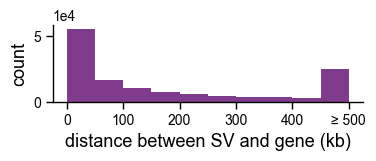

In [106]:
fig, ax = plt.subplots(1, figsize = (4, 1))
ax.hist(truncated_distances)
ax.set_xlabel('distance between SV and gene (kb)')
ax.set_ylabel('count')
ax.set_xticks([0, 1e5, 2e5, 3e5, 4e5, 5e5])
ax.set_xticklabels([0, 100, 200, 300, 400, '≥ 500'])
sns.despine()
fig.savefig('images/distance-between-intergenic-svs-and-genes.png', bbox_inches = 'tight')

In [107]:
intergenic_svs['distance'] = distances

In [108]:
intergenic_svs[['name', '#chrom', 'start_sv', 'end_sv', 'gene_name', 'start_gene', 'end_gene', 'distance']].to_csv('data/cwas-results/intergenic-sv-to-gene-distances.csv', index = False)

# Run gene set enrichment on the categories themselves

We end up running a ton of gene set enrichments in a variety of contexts for the CWAS results. I want to run the gene set enrichment for the categories at baseline here.

In [ ]:
category_gene_matrix = pd.read_csv('data/cwas-results/category-gene-matrix.csv').set_index('category')

We subset to significant categories, because these are the only ones that we care about.

In [111]:
framework_results.query('negative_log10_p_value > 3.0')['disease'].value_counts()

neuroblastoma    151
osteosarcoma      27
ewing             13
Name: disease, dtype: int64

In [116]:
analysis_categories = framework_results.query('negative_log10_p_value > 3.0')
analysis_category_gene_matrix = category_gene_matrix.loc[analysis_categories['category_name'].tolist()]

In [117]:
gene_ref = set(category_gene_matrix.columns)

Read in the gene sets

In [118]:
gene_sets = {}
with open('ref/gene-sets.txt') as gs_in:
    for line in gs_in:
        comp = line.strip().split('\t')
        db = comp[0]
        gs = comp[1]
        genes = comp[2:]
        gene_sets[db + ' | ' + gs] = genes

In [119]:
len(gene_sets)

26983

We convert both our gene sets and categories to sparse matrices.

In [82]:
import scipy.sparse

In [83]:
cat_gene_sparse_mtx = scipy.sparse.csr_matrix(analysis_category_gene_matrix.values)

In [86]:
cat_gene_sparse_mtx

<164x19092 sparse matrix of type '<class 'numpy.int64'>'
	with 1143473 stored elements in Compressed Sparse Row format>

In [87]:
gene_to_idx = {gene: i for i, gene in enumerate(analysis_category_gene_matrix.columns)}
cat_to_idx = {cat: i for i, cat in enumerate(analysis_category_gene_matrix.index)}

In [88]:
gs_to_idx = {}

values = []
row_indices = []
column_indices = []
for i, (gs, genes) in enumerate(gene_sets.items()):
    gs_to_idx[gs] = i
    
    column_indices += [gene_to_idx[g] for g in genes]
    row_indices += [i] * len(genes)
    values += [1] * len(genes)
    
values = np.array(values)
row_indices = np.array(row_indices)
column_indices = np.array(column_indices)

In [89]:
gs_gene_sparse_mtx = scipy.sparse.csr_matrix((values, (row_indices, column_indices)), 
                                             shape = (len(gs_to_idx), len(gene_to_idx))).T

In [90]:
gs_gene_sparse_mtx

<19092x26983 sparse matrix of type '<class 'numpy.int64'>'
	with 1008081 stored elements in Compressed Sparse Column format>

We use some nice matrix math to pull out all our elements for the contingency table.

In [91]:
cat_and_gs = cat_gene_sparse_mtx.dot(gs_gene_sparse_mtx).todense().A
cat_and_not_gs = (cat_gene_sparse_mtx.sum(axis = 1) - cat_and_gs).A
not_cat_and_gs = (gs_gene_sparse_mtx.sum(axis = 0) - cat_and_gs).A

# a bit of math
I = np.ones(shape = (cat_gene_sparse_mtx.shape[0], gs_gene_sparse_mtx.shape[1])) * cat_gene_sparse_mtx.shape[1]
not_cat_and_not_gs = (I - cat_and_not_gs - not_cat_and_gs - cat_and_gs)

We now pass this to our vectorized fishers exact test

In [92]:
categories = []
for c in analysis_category_gene_matrix.index:
    categories += [c] * cat_and_gs.shape[1]
    
gene_sets = list(gs_to_idx.keys()) * cat_and_gs.shape[0]

In [93]:
tp = cat_and_gs.ravel().astype(int)
fp = cat_and_not_gs.ravel().astype(int)
fn = not_cat_and_gs.ravel().astype(int)
tn = not_cat_and_not_gs.ravel().astype(int)

results = pyranges.statistics.fisher_exact(tp, fp, fn, tn, pseudocount = 0)
results['expected'] = pd.Series((fn + tp).astype(str)) + '/' + pd.Series((fp + tn + tp + fn).astype(str))
results['data'] = pd.Series((tp).astype(str)) + '/' + pd.Series((tp + fp).astype(str))
results['db'] = [string.split(' | ')[0] for string in gene_sets]
results['gs'] = [string.split(' | ')[1] for string in gene_sets]
results['category'] = categories

results = results[['db', 'gs', 'category', 'expected', 'data', 'OR', 'P']]
results = results.rename(columns = {'OR': 'odds_ratio', 'P': 'p'})

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pyranges/statistics.py:163: RuntimeWarning: invalid value encountered in true_divide
  OR = ((tp + pseudocount) / (fp + pseudocount)) / ((fn + pseudocount) / (tn + pseudocount))
/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pyranges/statistics.py:163: RuntimeWarning: divide by zero encountered in true_divide
  OR = ((tp + pseudocount) / (fp + pseudocount)) / ((fn + pseudocount) / (tn + pseudocount))


In [94]:
results.head(2)

,db,gs,category,expected,data,odds_ratio,p
0,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,199/19092,27/4851,0.457816,0.000054
1,MSigDB_Hallmark_2020,Hypoxia,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,200/19092,33/4851,0.577229,0.003174


In [95]:
results[results['category'].str.contains('\.neuroblastoma_H3K27Ac_peak\.')]

,db,gs,category,expected,data,odds_ratio,p
539660,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,ANY.SINGLETON.PREDICTED_NONCODING_SPAN.neurobl...,199/19092,48/2758,1.898253,2.415551e-04
539661,MSigDB_Hallmark_2020,Hypoxia,ANY.SINGLETON.PREDICTED_NONCODING_SPAN.neurobl...,200/19092,33/2758,1.172358,4.179790e-01
539662,MSigDB_Hallmark_2020,Cholesterol Homeostasis,ANY.SINGLETON.PREDICTED_NONCODING_SPAN.neurobl...,74/19092,12/2758,1.146912,6.203714e-01
539663,MSigDB_Hallmark_2020,Mitotic Spindle,ANY.SINGLETON.PREDICTED_NONCODING_SPAN.neurobl...,199/19092,86/2758,4.620204,1.222229e-06
539664,MSigDB_Hallmark_2020,Wnt-beta Catenin Signaling,ANY.SINGLETON.PREDICTED_NONCODING_SPAN.neurobl...,42/19092,20/2758,5.416030,3.025095e-07
...,...,...,...,...,...,...,...
2131652,GO_Biological_Process_Full,positive regulation of behavioral fear respons...,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,7/19092,1/2758,0.987063,1.000000e+00
2131653,GO_Biological_Process_Full,positive regulation of tyrosine 3-monooxygenas...,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,1/19092,0/2758,0.000000,1.000000e+00
2131654,GO_Biological_Process_Full,visual system development (GO:0150063),ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,382/19092,107/2758,2.357001,2.054991e-06
2131655,GO_Biological_Process_Full,negative regulation of dendritic cell cytokine...,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,2/19092,0/2758,0.000000,1.000000e+00


# FDR correction

No analysis is complete without an FDR correction. Thankfully, we get to throw out tests that can't possibly yield in a significant result. We've already calculated what we need, so we'll be a bit fancy.

In [97]:
for cat in analysis_categories['category_name'].tolist():
    for db in results['db'].unique():
        cat_db_result = results[(results['db'] == db) &
                                (results['category'] == cat)]
        
        fdr_p = statsmodels.stats.multitest.multipletests(cat_db_result['p'].to_list(), method='fdr_bh')[1]
        results.loc[cat_db_result.index, 'fdr_p'] = fdr_p

In [98]:
results.to_csv('data/cwas-results/category-gene-set-raw-significance.csv', index=False)

# How to handle counts?

In our analysis notebook, we'll need to handle _counts_ rather than just overlaps. Let's make sure we understand how to do this.

In [99]:
M = np.array([[1, 4, 0, 2], [2, 3, 1, 0], [0, 3, 4, 1], [0, 0, 0, 1]])
N = np.array([[1, 0, 0, 1], [0, 1, 1, 1], [1, 0, 1, 1], [0, 0, 0, 1]])

M_and_N = M.dot(N)
M_and_notN = M.sum(axis = 1).reshape(-1, 1) - M_and_N
notM_and_N = N.sum(axis = 0).reshape(1, -1) - M.astype(bool).dot(N)

I = np.ones(shape = (M.shape[0], N.shape[1])) * M.shape[1]
notM_and_notN = I - M.astype(bool).sum(axis = 1).reshape(-1, 1) - N.sum(axis = 0).reshape(1, -1) + M.astype(bool).dot(N)

Essentially, the top row of the contigency table uses counts, but the bottom row uses binary presence/absence. So you just have to be careful with conversion to boolean for bottom row elements.